In [80]:
# You only have to retrieve the token once. If it's already present in the project folder, then don't run the script

import json, requests, webbrowser, urllib

def authorize_app(client_id, redirect_uri = None):
    '''
        The function generates an url, which redirects to login page (optional, if not logged in) and app authorization. 
    '''
    if redirect_uri == None:
        redirect_uri = 'https://oauth.vk.com/blank.html' # default callback url
    oauth = requests.get('https://oauth.vk.com/authorize', params = {'client_id' : str(client_id), 
                                                                    'redirect_uri' : redirect_uri,
                                                                    'display' : 'page',
                                                                    'scope' : ['friends,offline'], # offline option makes the token permanent
                                                                    'response_type' : 'token',
                                                                    'v' : 5.63})
    return oauth.url

# test client id: 5842359
# Client ID of an app is stored in its settings
if not os.path.isfile('./token.txt'):
    client_id = input('Please supply app ID: ')
    url = authorize_app(client_id)
    print url
    webbrowser.open(url)
    # Access token is in the address bar of the newly opened tab. Copy and save it in token.txt

In [84]:
import json, requests, os

class VkAccess:
    '''
        This class will be used only to call 3 methods: get user name, user friends and get mutual friends
    '''
    def __init__(this, user_id):
        path = './token.txt'
        if os.path.isfile(path):
            with open(path, 'r') as f:
                this.token = f.read()
        else:
            print 'No access token available'
        this.user_id = user_id
        this.session = requests.session()
        this.friends = []
        this.mutual_friends = {}
        this.nodes = []
        this.edges = []
    
    def make_request(this, method, params):
        '''
            Generate request url for a particular API @method
        '''
        url = 'https://api.vk.com/method/%s?v=5.52&access_token=%s' % (method, str(this.token))
        response = this.session.get(url, params = params)
        return response
    
    def get_user_info(this):
        params = {'user_ids' : str(this.user_id), 'fields' : ['first_name', 'last_name']}
        response = this.make_request('users.get', params)
        
    def get_friends(this):
        '''
            Returns a list of friends
        '''
        params = {'user_id' : str(this.user_id), 'fields' : ['first_name', 'last_name']}
        response = this.make_request('friends.get', params)
        this.friends += json.loads(response.text)['response']['items']
        
    def execute(this):
        '''
            Mutual friends are requested via execute method that allows making 25 requests at once
            This is due to vk's restriction to make no more than 3 requests a second. 
        '''
        n = len(this.friends)
        for i in range(0, n, 25):
            '''
                The only parameter passed to execute is code written in VkScript. 
                We put 25 getMutual(user_id, next_id) requests in this code
            '''
            params = {'code' : 'return ['}
            for j in range(i, min(n, i + 25)):
                params['code'] += 'API.friends.getMutual({"source_uid" : ' + str(this.user_id) + ', "target_uid": ' + str(this.friends[j]['id']) + '}), ' 
            params['code'] += '];'
            response = this.make_request('execute', params)
            response = json.loads(response.text)['response']
            '''
                Note: this.mutual_friends is a dictionary with entries (friend_id : [mutual_friend_ids])
            '''
            this.mutual_friends.update({key['id'] : value for (key, value) in zip(this.friends[i:(i + 25)], response)})
    
    def generate_graph(this):
        '''
            Generate nodes and edges for the graph
        '''
        id_name = {x['id'] : (x['first_name'] + ' ' + x['last_name']).encode('utf8') for x in this.friends}
        this.nodes = [(x['first_name'] + ' ' + x['last_name']).encode('utf8') for x in this.friends]
        this.edges = []
        for friend in this.mutual_friends.keys():
            if this.mutual_friends[friend]:
                for i in this.mutual_friends[friend]:
                    if i:
                        this.edges.append((id_name[friend], id_name[i]))
        

user_id = raw_input("Please supply user_id: ")
vk = VkAccess(user_id)
vk.get_user_info()
vk.get_friends()
vk.execute()
vk.generate_graph()

Please supply user_id: 


KeyError: 'response'

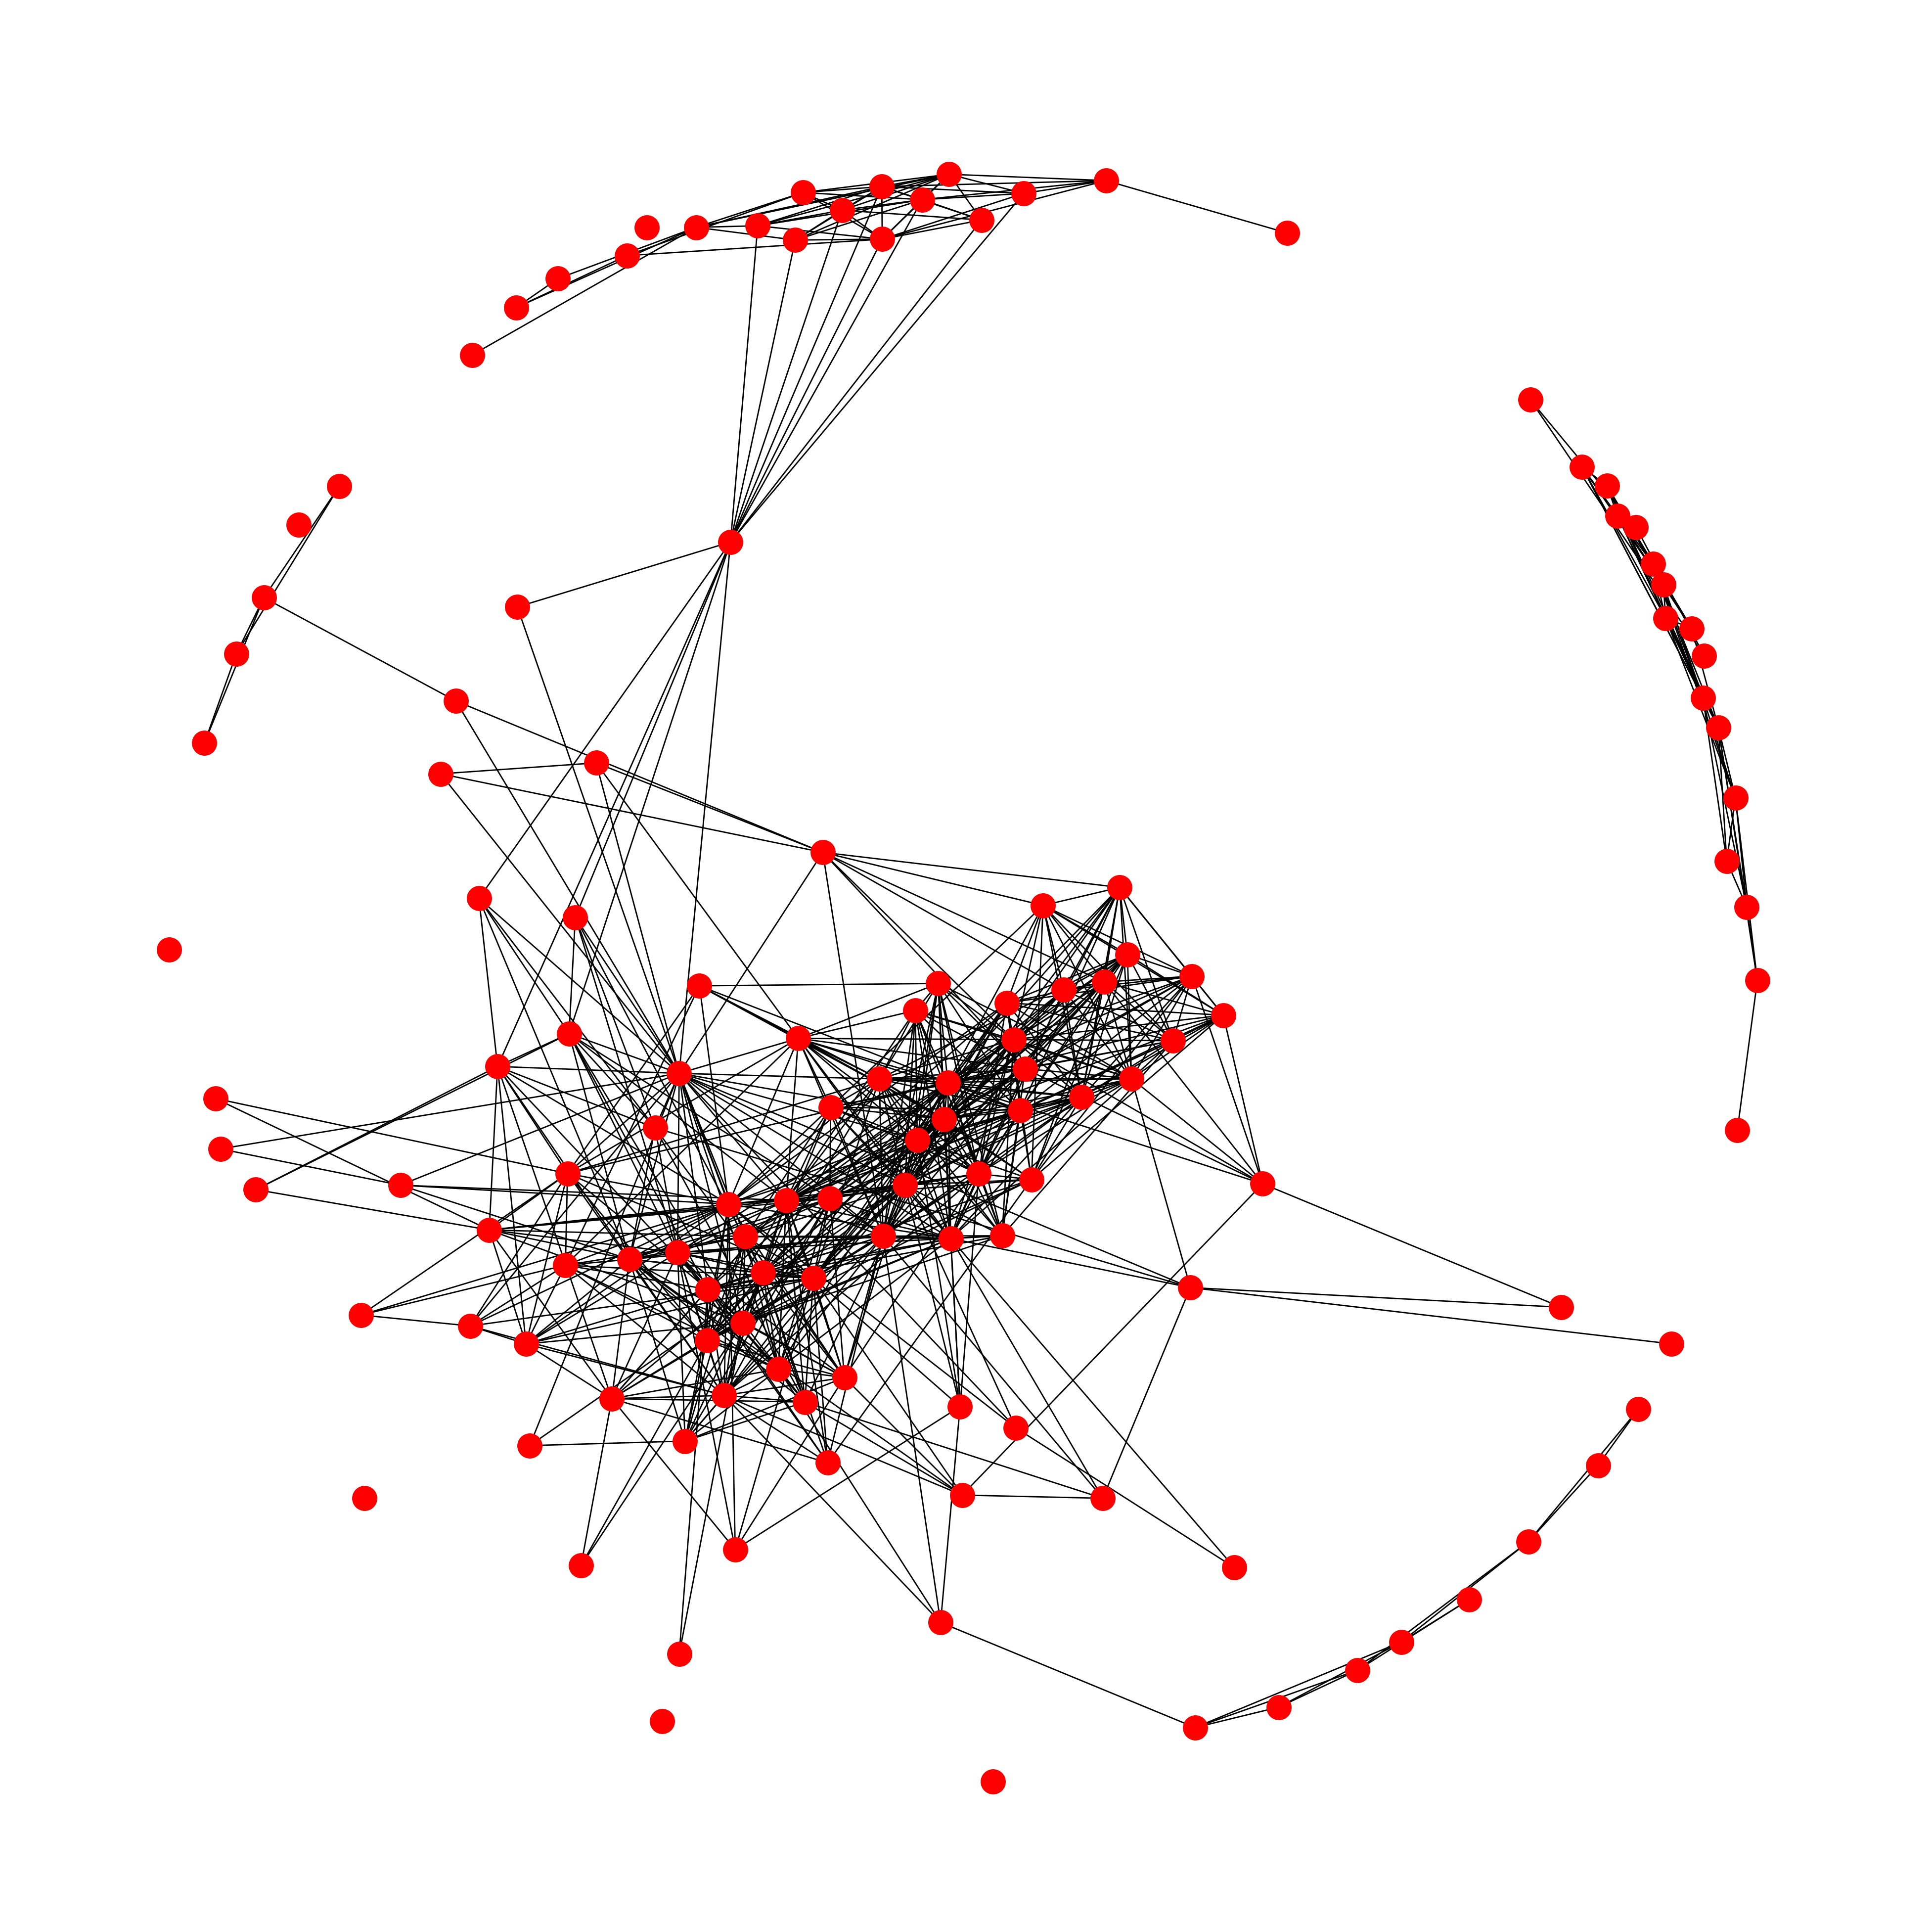

In [82]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


def draw_graph(vk, show_names = False, save = True):
    '''
        The resulting figure may or may not display friends' names
        depending on the @show_names value. In case there are more than 200 friends,
        it makes sense to hide names since the plot will be a mess.
        @save indicates whether or not to save the plot locally
    '''
    G = nx.Graph()
    G.add_nodes_from(vk.nodes)
    G.add_edges_from(vk.edges)
    k = nx.degree(G)
    plt.figure(1, figsize = (19, 19), dpi = 200)
    coord = nx.spring_layout(G)
    if show_names:
        nx.draw_networkx(G,
                             pos=nx.spring_layout(G),
                             nodelist=k.keys(),
                             node_size = [(d + 1)*10 for d in k.values()],
                             node_color=k.values(),
                             font_size=10,
                             )
    else:
        nx.draw(G)
    
    if save:
        plt.savefig('./Graph.png', format="PNG")
        
draw_graph(vk, show_names = False)